# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# disabling warnings entirely
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import sys
sys.path.append("..")

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [4]:
# Read data
data = pd.read_csv(r'C:\Users\nikita.saprykin\Desktop\RCS\урок_6\retail_train.csv')
item_features = pd.read_csv(r'C:\Users\nikita.saprykin\Desktop\RCS\урок_6\product.csv')
user_features = pd.read_csv(r'C:\Users\nikita.saprykin\Desktop\RCS\урок_6\hh_demographic.csv')

In [5]:
# Process features dataset
ACTUAL_COL = 'actual'
USER_COL = 'user_id'
ITEM_COL = 'item_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL}, inplace=True)

In [6]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 6

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")


In [8]:
#Prefilter items
take_n_popular = 5000

n_items_before = data_train_lvl_1[ITEM_COL].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=take_n_popular)

n_items_after = data_train_lvl_1[ITEM_COL].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 82059 to 5001


In [9]:
# ищем общих пользователей
common_users = data_train_lvl_1.user_id.values

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]


In [10]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна




In [11]:
%%time
# N = Neighbors
N_PREDICT = 50 

result_lvl_1 = data_val_lvl_1.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_lvl_1.columns=[USER_COL, ACTUAL_COL]

D_FRAME = result_lvl_1

# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции

D_FRAME['own_rec'] =\
D_FRAME[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

D_FRAME['sim_item_rec'] =\
D_FRAME[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))

D_FRAME['als_rec'] =\
D_FRAME[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))


AttributeError: 'MainRecommender' object has no attribute 'get_own_recommendations'

In [12]:
# простой пример как можно обернуть в функцию

def evalRecall_at_k(df_result, target_col_name, recommend_model,N_PREDICT=50,top_k=50):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N_PREDICT))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

def evalPrecision_at_k(df_result, target_col_name, recommend_model,N_PREDICT=50,top_k=50):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N_PREDICT))
    return df_result.apply(lambda row: precision_at_k(row[result_col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

# генераторы
def calc_recall_at_k(df_data, top_k=50):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()
        
def calc_precision_at_k(df_data, top_k=50):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [13]:
sorted(calc_recall_at_k(D_FRAME, 50), key=lambda x: x[1],reverse=True)

[]

In [17]:
sorted(calc_precision_at_k(D_FRAME, 50), key=lambda x: x[1],reverse=True)

[('own_rec', 0.11685424354243559),
 ('als_rec', 0.08738929889298921),
 ('sim_item_rec', 0.06393911439114419)]

### Лучший результат дает метод get_own_recommendations

# B)* Как зависит recall@k от k? 
Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [18]:
%%time

rers_k_test=dict()
val = evalRecall_at_k(D_FRAME, USER_COL, recommender.get_own_recommendations,N_PREDICT=50,top_k=50)
val2 = evalPrecision_at_k(D_FRAME, USER_COL, recommender.get_own_recommendations,N_PREDICT=50,top_k=50)
rers_k_test[50] = [val, val2]
rers_k_test

Wall time: 1min 2s


{50: [0.09887244421807027, 0.11685424354243559]}

In [19]:
%%time

# Поскольку в нашу модель прошивается К на этапе предсказаний - для того, чтобы 
# понять как зависит точность от К каждый раз надо пересчитывать модель. 
# Иначе точность замрёт на К = К модели

k_list = (20, 100, 200, 500)
for top_k in k_list:
    val = evalRecall_at_k(D_FRAME, USER_COL, recommender.get_own_recommendations,N_PREDICT=top_k,top_k=top_k)
    val2 = evalPrecision_at_k(D_FRAME, USER_COL, recommender.get_own_recommendations,N_PREDICT=top_k,top_k=top_k)
    rers_k_test[top_k] = [val, val2]

Wall time: 4min 12s


<AxesSubplot:xlabel='K_value'>

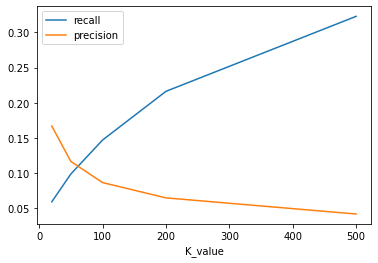

In [20]:
summary = pd.DataFrame.from_dict(rers_k_test,orient='index',columns=['recall', 'precision'])
summary.index.name = 'K_value'
summary.sort_values(by='K_value').plot()


### Дают ли own recommendtions + top-popular лучший recall?  
да

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


### Задание 2.

Обучите модель 2-ого уровня, при этом:


    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар


- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2



- Вырос ли precision@5 при использовании двухуровневой модели?

In [21]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_lvl_2[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [22]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [23]:
# df_match_candidates.head(2)

In [24]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [25]:
# df_match_candidates.head(4)

In [26]:
### Check warm start
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (108400, 2) Users: 2168 Items: 4890


In [27]:
### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [28]:
# dask dataframe

df_ranker_train = data_train_lvl_2[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [29]:
# df_ranker_train.target.value_counts()
df_ranker_train.head(2)

,user_id,item_id,target
0,790,1100273,1.0
1,790,1125391,0.0


In [30]:
df_ranker_train['target'].mean()

0.17381244280213423

## Подготавливаем фичи для обучения модели

In [31]:
user_features.age_desc.unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [32]:
user_features.income_desc.unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [33]:
# # Подготавливаем фичи для обучения модели

# 2 фичmи...

# для юзера
user_features['millenial'] = 0
user_features.loc[(user_features['age_desc']=='25-34' ), 'millenial'] = 1
user_features.loc[(user_features['age_desc']=='19-24' ), 'millenial'] = 1


user_features['yong_reach'] = 0
user_features.loc[((user_features['age_desc']=='19-24' ) & (user_features['income_desc']=='250K+' )), 'yong_reach'] = 1

# для товара
item_features['premium'] = 0
item_features.loc[(item_features['sub_commodity_desc'].str.contains("premium", case=False)), 'premium'] = 1
# item_features['premium'].sum()

item_features['veggie_unfriendly'] = 0
item_features.loc[(item_features['commodity_desc'].str.contains("MEAT", case=False)), 'veggie_unfriendly'] = 1
# item_features['veggie_unfriendly'].sum()

df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,premium,veggie_unfriendly,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,millenial,yong_reach
0,790,1100273,1.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,13 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
1,790,1125391,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,12 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
2,790,1139569,1.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
3,790,1030836,0.0,1251,GROCERY,National,MEAT - SHELF STABLE,PASTA: CANNED,14.75 OZ,0,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
4,790,1040812,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,12.0 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115821,1565,1033142,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115822,1565,847982,0.0,1646,PRODUCE,National,SALAD MIX,REGULAR GARDEN,1 LB,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115823,1565,845208,0.0,69,PRODUCE,Private,ONIONS,ONIONS YELLOW (BULK&BAG),3 LB,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115824,1565,833025,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,SOUR CREAMS,16 OZ,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# user_features.head(2)

In [34]:
# 2 фичmи...
# для пары юзер-товар

# df_ranker_train['reach_vegan'] = 0

# df_ranker_train.loc[((df_ranker_train['veggie_unfriendly'] == 0) &\
#                      (df_ranker_train['income_desc_x'] == '200-249K')), 'reach_vegan'] = 1



In [35]:
df_ranker_train['premium'] = 0
df_ranker_train.loc[(df_ranker_train['sub_commodity_desc'].str.contains("premium", case=False)), 'premium'] = '1'
df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,premium,veggie_unfriendly,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,millenial,yong_reach
0,790,1100273,1.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,13 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
1,790,1125391,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,12 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
2,790,1139569,1.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
3,790,1030836,0.0,1251,GROCERY,National,MEAT - SHELF STABLE,PASTA: CANNED,14.75 OZ,0,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0
4,790,1040812,0.0,320,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,12.0 OZ,1,1,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,0.0,0.0


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [36]:
# df_ranker_train.head(2)

In [37]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [38]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')
cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'premium',
 'veggie_unfriendly',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'millenial',
 'yong_reach']

In [39]:
## Обучение модели ранжирования
# на покупках из сета data_train_ranker и на кандитатах от own_recommendations, 
# что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [40]:
df_ranker_predict = df_ranker_train.copy()

In [41]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [42]:
# df_ranker_predict.head(2)

In [43]:
# Evaluation on test dataset

result_eval_ranker = data_val_lvl_2.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
# result_eval_ranker.head(2)

In [44]:
%%time
result_eval_ranker['own_rec'] = \
result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 31.4 s


In [45]:
# померяем precision@5 только модели 1 уровня
print(*sorted(calc_precision_at_k(D_FRAME, 5), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.2560885608856074)
('result', 0.2560885608856074)
('als_rec', 0.15571955719557007)
('sim_item_rec', 0.1047047970479697)


In [46]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].\
sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [47]:
# померяем precision@5 только модели 2 уровня

In [48]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [49]:
print(*sorted(calc_precision_at_k(result_eval_ranker, 5), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.25503416856491934)
('reranked_own_rec', 0.19537401574802854)


 Модель 1 уровня лучше